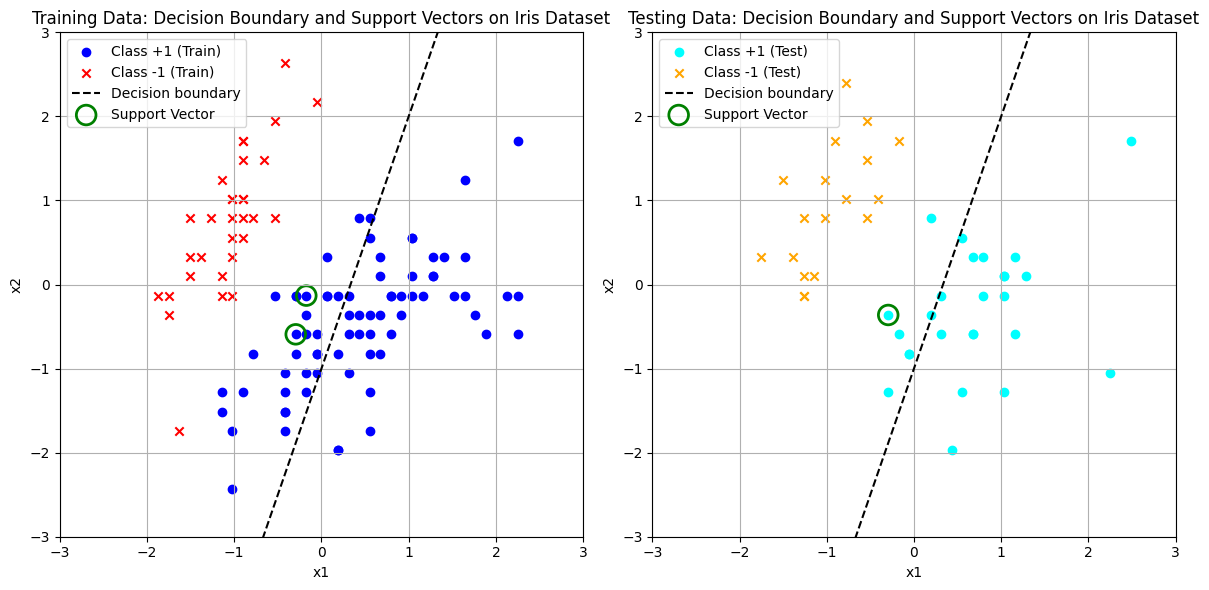

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import GroverOperator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load real-world dataset (e.g., Iris dataset)
iris = None 
X =  None   # We only need to use the first two features for visualization
y = (iris.target != 0) * 2 - 1  # Binary classification: label 1 for class 1, -1 for others

# Standardize the dataset using StandardScaler
scaler = 
X_scaled = 

# Train-test split 
X_train, X_test, y_train, y_test = 

data = {
    'x': X_train,
    'y': y_train
}

# 2. Discretization of weights and bias (3-bit precision for simplicity)
precision = 3  # 3-bit precision (8 values for each parameter)
w1_values = np.linspace(-5, 5, 2**precision)  # 8 values for w1
w2_values = np.linspace(-5, 5, 2**precision)  # 8 values for w2
b_values = np.linspace(-5, 5, 2**precision)   # 8 values for b



discretized_params = None #make sets of each possible values of W_1,W_2 and b

N = len(discretized_params)  # Total number of parameter combinations

# 3. Adjust the number of qubits 
n_qubits = None  # Number of qubits to represent discretized states
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits) 
qc = QuantumCircuit(qr, cr)

# 4. Initialize in uniform superposition
qc.h(qr)

# 5. Nonconvex loss function (inspired by hinge loss)
def nonconvex_loss(w1, w2, b, data):
    loss = 0
    for (x1, x2), y in zip(data['x'], data['y']):
        margin = y * (w1 * x1 + w2 * x2 + b)
        if margin < 1:  # Misclassified points
            loss += (1 - margin) ** 2  # Nonconvex penalty (quadratic penalty)
    return loss

# 6. Define the oracle circuit for Grover's search
def svm_oracle(qr):
    oracle_circuit = QuantumCircuit(qr)
    min_loss_threshold = 1e-2  # Threshold for marking the best solution
    for index, (w1, w2, b) in enumerate(discretized_params):
        # Evaluate the nonconvex cost function
        loss = nonconvex_loss(w1, w2, b, data)
        
        if loss < min_loss_threshold:  # Mark this state as a solution if it meets the loss threshold
            # Convert index to binary
            index_binary = format(index, f'0{n_qubits}b')
            for i, bit in enumerate(reversed(index_binary)):
                if bit == '1':
                    oracle_circuit.z(i)  # Apply Z gate on the corresponding qubit
    return oracle_circuit

# Create the oracle circuit using Quantum Circuit qr
oracle = 

# 7. Apply Grover's operator for amplitude amplification on the oracle
grover_operator = None

# Apply Grover's operator to amplify the valid states
qc.compose(grover_operator, inplace=True)

# 8. Measurement to collapse and find the optimal (w1, w2, b)
qc.measure(qr, cr)

# 9. Transpile and simulate the quantum circuit using the AerSimulator backend
backend = AerSimulator()
transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, shots=2048).result()
counts = result.get_counts()

# 10. Find the most probable state (i.e., the optimal w1, w2, b combination)
most_probable_state = max(counts, key=counts.get)
index = int(most_probable_state, 2)
optimal_w1, optimal_w2, optimal_b = discretized_params[index]

# 11. Plot both training and testing data points, along with the decision boundary
plt.figure(figsize=(12, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
plt.title("Training Data: Decision Boundary and Support Vectors on Iris Dataset")

# Plot training positive and negative points
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label="Class +1 (Train)", marker='o')
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label="Class -1 (Train)", marker='x')

# Plot the decision boundary
x_vals = np.linspace(-3, 3, 100)  # Adjusted for standardized data range
y_vals = -(optimal_w1 / optimal_w2) * x_vals - (optimal_b / optimal_w2)
plt.plot(x_vals, y_vals, '--', color='black', label=f'Decision boundary')

# Highlight the support vectors (points near the decision boundary)
for (x1, x2), y in zip(data['x'], data['y']):
    margin = y * (optimal_w1 * x1 + optimal_w2 * x2 + optimal_b)
    if abs(margin - 1) < 0.1:  # Support vectors should lie close to margin 1
        plt.scatter(x1, x2, s=200, facecolors='none', edgecolors='green', linewidths=2, label="Support Vector" if 'Support Vector' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)

# Subplot for Testing Data
plt.subplot(1, 2, 2)
plt.title("Testing Data: Decision Boundary and Support Vectors on Iris Dataset")

# Plot testing positive and negative points
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='cyan', label="Class +1 (Test)", marker='o')
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='orange', label="Class -1 (Test)", marker='x')

# Plot the decision boundary from training
plt.plot(x_vals, y_vals, '--', color='black', label=f'Decision boundary')

# Highlight support vectors for the testing dataset
for (x1, x2), y in zip(X_test, y_test):
    margin = y * (optimal_w1 * x1 + optimal_w2 * x2 + optimal_b)
    if abs(margin - 1) < 0.1:  # Support vectors should lie close to margin 1
        plt.scatter(x1, x2, s=200, facecolors='none', edgecolors='green', linewidths=2, label="Support Vector" if 'Support Vector' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
